In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import minimize
import scipy.io

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px


1. Function definitions & Global configuration parameters

In [ ]:
# Configuration parameters
num_channels = 128
length_timebins = 127457 
num_trials = 640

length_timebins_s2 = 159136
num_trials2_s2 = 800


# Load file
filepath = r"F:\RiceStudy\BCI\speech_neuroprosthesis\data\tuningTasks"
filename = "t12.2022.04.21_phonemes.mat"
matfile_path = os.path.join(filepath, filename)
tuning_data = scipy.io.loadmat(matfile_path)

filename = "t12.2022.04.26_phonemes.mat"
matfile_path = os.path.join(filepath, filename)
tuning_session2 = scipy.io.loadmat(matfile_path)


# Generate "phoneme - neural activty" chart
# Extract neural activity and phonemes records
## Phonemes are recorded in tuning_data['trailCues']

## Phonemes chart
phonemes_chart = ['B','CH','NOTHING','D','F','G','HH','JH','K','L','ER','M','N','NG','P','R','S','SH','DH','T','TH', 'V','W',\
    'Y','Z','ZH','OY','EH','EY','UH','IY','OW','UW','IH','AA','AW','AY','AH','AO','AE']

consonant_clusteredchart = ['M', 'B', 'P', 'F', 'V', 'W', 'T', 'TH', 'DH', 'D', 'N', 'L', 'S', 'Z', 'CH', 'SH', 'ZH', 'JH', 'NG', 'K', 'G', 'Y', 'R']
vowel_clusteredchart = ['OW', 'AO', 'AA', 'AW', 'AY', 'EH', 'AE', 'EY', 'IY', 'IH', 'AH', 'ER', 'OY', 'UW', 'UH', 'HH', 'NOTHING']

phoneme_clusteredchart = np.append(consonant_clusteredchart[:], vowel_clusteredchart[:])

## extract and rearrange neural activities
### def Z-score. input a 1d numpy array
def z_score(arr):
    x = np.array(arr.copy())
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std


### def subtraction mean. input a 2-2 numpy array. default mean by axis 0
def subt_mean(arr, axis = 0):
    x = np.array(arr.copy())
    mean = np.mean(x, axis = axis)
    if axis == 0:
        return x - mean
    if axis == 1:
        return (x.T - mean).T
    

## similarity by angle between
### def of cross product calculation
def cross_product(x, y):
    if len(x) != len(y):
        return 0
    
    t = 0
    for i in range(len(x)):
        t += x[i] * y[i]

    return t

### def of representation similarity calculation
def repre_similarity(x, y):
    if cross_product(x, x) == 0 or cross_product(y, y) == 0:
        return 0
    if len(x) != len(y):
        return 0
    
    t = 0
    return cross_product(x, y) / np.sqrt(cross_product(x, x)) / np.sqrt(cross_product(y, y))


## similarity by (fake-CKA)
### def of centered kernal
def centered_kernal(x): # input variable: 1-d array/list
    n = len(x)
    matGram = np.array(x).reshape(n, 1) @ np.array(x).reshape(1, n)
    matH = np.eye(n) - np.ones((n, n)) / n
    return matH @ matGram @ matH

### def of (fake-)CKA
def ckalike_similarity(x, y):
    tX = centered_kernal(x)
    tY = centered_kernal(y)
    return np.trace(tX @ tY) / np.sqrt(np.trace(tX @ tX)) / np.sqrt(np.trace(tY @ tY))


#### extract according to audio envelope's peak
def generate_phonemesdict_audio(tuning_data, length_timebins, num_channels):
    gotrial_start = np.array(tuning_data['goTrialEpochs'][:, 0])
    gotrial_end = np.array(tuning_data['goTrialEpochs'][:, 1])
    
    global phonemes_chart
    phonemes_indices = {}
    for i in range(len(phonemes_chart)):
        key = phonemes_chart[i]
        value = np.where(tuning_data['trialCues'] == (i + 1))[0]
        phonemes_indices[key] = value

    ### list of maximum audio time for each trial
    classifier_labels = []
    classifier_features = []

    ### Slice phonemese with aligenment by audio envelope, z-scored globally
    slicecut_left = 40
    slicecut_right = 0
    sp_temp = z_score(tuning_data['spikePow'][:, : num_channels].copy())

    phonemes_neuralact = {}
    for i in range(len(phonemes_chart)):
        trial_begins = [max(0, gotrial_start[phonemes_indices[phonemes_chart[i]][j]] - 10) for j in range(len(phonemes_indices[phonemes_chart[i]]))]
        trial_ends = [min(length_timebins, gotrial_end[phonemes_indices[phonemes_chart[i]][j]] - 10) for j in range(len(phonemes_indices[phonemes_chart[i]]))]

        trialslice_sp = np.zeros(num_channels)

        for j in range(len(phonemes_indices[phonemes_chart[i]])): # iterate by trials for each phoneme/condition
            audio_loudest = max(tuning_data['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]])
            audio_loudest_index = np.where(tuning_data['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]] == audio_loudest)[0][0] + trial_begins[j] - 1

            slice_left = audio_loudest_index - slicecut_left
            slice_right = audio_loudest_index + slicecut_right

            ### read a trial's neural activity data
            if slice_left >= 0 and slice_right <= length_timebins:
                trialslice_sp_temp = sp_temp[slice_left : slice_right, :] # Spike Power

            elif slice_left < 0:
                tempp_zeros = np.zeros((0 - slice_left, num_channels)) # contemporarily supplementary array
                trialslice_sp_temp = np.concatenate((tempp_zeros, sp_temp[slice_left : slice_right, :] )) # Spike Power

            elif slice_right > length_timebins:
                tempp_zeros = np.zeros((slice_right - length_timebins, num_channels)) # contemporarily supplementary array
                trialslice_sp_temp = np.concatenate((sp_temp[slice_left : slice_right, :] , tempp_zeros)) # Spike Power

            trialslice_sp_temp = np.mean(trialslice_sp_temp, axis = 0)
            trialslice_sp = trialslice_sp + trialslice_sp_temp

            classifier_labels.append(np.where(phoneme_clusteredchart == phonemes_chart[i])[0][0])
            classifier_features.append(trialslice_sp_temp)

        trialslice_sp /= len(phonemes_indices[phonemes_chart[i]])
        key = phonemes_chart[i]
        phonemes_neuralact[key] = trialslice_sp

    classifier_features = subt_mean(classifier_features)   
    return phonemes_neuralact, classifier_labels, classifier_features


#### extract according to Go-cues
def generate_phonemesdict_gocue(tuning_data, length_timebins, num_channels, delay_times = 40*np.ones(len(phonemes_chart))):
    gotrial_start = np.array(tuning_data['goTrialEpochs'][:, 0])
    
    global phonemes_chart
    phonemes_indices = {}
    for i in range(len(phonemes_chart)):
        key = phonemes_chart[i]
        value = np.where(tuning_data['trialCues'] == (i + 1))[0]
        phonemes_indices[key] = value

    ### list of maximum audio time for each trial
    classifier_labels = []
    classifier_features = []

    ### Slice phonemese with aligenment by audio envelope, z-scored globally
    delay = np.mean(delay_times[phonemes_chart[i]])
    slicecut_left = int(- delay + 40)
    slicecut_right = int(delay)

    sp_temp = tuning_data['spikePow'][:, : num_channels].copy()

    phonemes_neuralact = {}
    for i in range(len(phonemes_chart)):
        trial_begins = [gotrial_start[phonemes_indices[phonemes_chart[i]][j]] for j in range(len(phonemes_indices[phonemes_chart[i]]))]

        trialslice_sp = np.zeros(num_channels)

        for j in range(len(phonemes_indices[phonemes_chart[i]])): # iterate by trials for each phoneme/condition
            slice_left = trial_begins[j] - slicecut_left
            slice_right = trial_begins[j] + slicecut_right

            ### read a trial's neural activity data
            if slice_left >= 0 and slice_right <= length_timebins:
                trialslice_sp_temp = sp_temp[slice_left : slice_right, :] # Spike Power

            elif slice_left < 0:
                tempp_zeros = np.zeros((0 - slice_left, num_channels)) # contemporarily supplementary array
                trialslice_sp_temp = np.concatenate((tempp_zeros, sp_temp[slice_left : slice_right, :] )) # Spike Power

            elif slice_right > length_timebins:
                tempp_zeros = np.zeros((slice_right - length_timebins, num_channels)) # contemporarily supplementary array
                trialslice_sp_temp = np.concatenate((sp_temp[slice_left : slice_right, :] , tempp_zeros)) # Spike Power

            trialslice_sp_temp = np.mean(trialslice_sp_temp, axis = 0)
            trialslice_sp = trialslice_sp + trialslice_sp_temp

            classifier_labels.append(np.where(phoneme_clusteredchart == phonemes_chart[i])[0][0])
            classifier_features.append(trialslice_sp_temp)

        trialslice_sp /= len(phonemes_indices[phonemes_chart[i]])

        key = phonemes_chart[i]
        phonemes_neuralact[key] = trialslice_sp # an averaged activity for each phoneme
        
    mean = np.mean(classifier_features)
    std = np.std(classifier_features)
    for k, _ in phonemes_neuralact.items():
        phonemes_neuralact[k] -= mean
        phonemes_neuralact[k] /= std
    classifier_features = z_score(classifier_features)   
    return phonemes_neuralact, np.array(classifier_labels), np.array(classifier_features)


### def mix classifier by RandomForestClassifier
def mix_bi_RandomForestClassifier(sample_s1, sample_s2, classifier_features, classifier_labels, classifier_features_s2, classifier_labels_s2):
    ### take training samples from session1 and session 2
    arr = np.arange(len(tuning_data['trialCues'])) #### extract from session1
    trainingindex = np.random.choice(arr, sample_s1, replace = False)
    X_train_1, y_train_1 = classifier_features[trainingindex], classifier_labels[trainingindex]

    arr = np.arange(len(tuning_session2['trialCues'])) #### extract from session2
    trainingindex = np.random.choice(arr, sample_s2, replace = False)
    X_train_2, y_train_2 = classifier_features_s2[trainingindex], classifier_labels_s2[trainingindex]

    X_train = np.concatenate((X_train_1, X_train_2), axis = 0)
    y_train = np.append(y_train_1, y_train_2)

    testindex = ~np.isin(arr, trainingindex)
    X_test, y_test = classifier_features_s2[testindex], classifier_labels_s2[testindex]

    ### train
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # print(classification_report(y_test, y_pred))
    # cm = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cm, annot=False, cmap="Blues")
    # plt.title(f"Confusion Matrix: mix session1 and session2 for train, sklearn classifier")
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation = 60)
    # plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation = 0)
    # plt.show()
    # plt.clf()

    return y_test, y_pred


## Affine transformations
def affine_transform(X, params):
    """
    Applies an affine transformation to X using given parameters.
    Parameters:
    - X: (N, d) array of source data
    - params: Flattened array containing A (dxd) and b (dx1)
    Returns:
    - Transformed (N, d) array
    """
    d = X.shape[1]
    A = params[:d**2].reshape(d, d)  # Reshape first d^2 elements into a (dxd) matrix
    b = params[d**2:].reshape(1, d)  # Last d elements form (1xd) translation vector
    return X @ A.T + b  # Apply affine transformation


def objective_function(params, X_source, X_target, similarity_metric):
    """
    Objective function to maximize similarity between transformed X_source and X_target.
    Parameters:
    - params: Flattened affine transformation parameters
    - X_source: Original dataset (N, d)
    - X_target: Target dataset (N, d)
    - similarity_metric: Function to compute similarity
    Returns:
    - Negative similarity (since we minimize in `scipy.optimize.minimize`)
    """
    X_transformed = affine_transform(X_source, params)
    return similarity_metric(X_transformed, X_target)  # Negate for minimization


def objective_gradient(params, X_source, X_target, similarity_metric):
    """
    Computes the gradient of the objective function w.r.t. the parameters.
    """
    d = X_source.shape[1]
    A = params[:d**2].reshape(d, d)
    b = params[d**2:].reshape(1, d)
    X_transformed = X_source @ A.T + b

    # Compute the gradient w.r.t. the similarity metric (using negative MSE as an example)
    grad_X = 2 * (X_transformed - X_target) / len(X_source)
    
    # Gradient w.r.t. A
    grad_A = X_source.T @ grad_X
    
    # Gradient w.r.t. b
    grad_b = np.sum(grad_X, axis=0)

    # Flatten and concatenate gradients
    grad = np.hstack([grad_A.T.flatten(), grad_b])
    return grad


def optimize_affine_transformation(X_source, X_target, similarity_metric):
    """
    Finds the optimal affine transformation maximizing a given similarity metric.
    Parameters:
    - X_source: Original dataset (N, d)
    - X_target: Target dataset (N, d)
    - similarity_metric: Function that computes similarity score
    Returns:
    - Optimal affine transformation matrix A and translation vector b
    """
    d = X_source.shape[1]
    # Initialize parameters: Identity matrix for A and zero vector for b
    init_params = np.hstack([np.eye(d).flatten(), np.zeros(d)])
    # Optimize
    result = minimize(
        objective_function,
        init_params,
        args=(X_source, X_target, similarity_metric),
        method="L-BFGS-B",
        # jac=objective_gradient
    )
    # Extract optimal parameters
    A_opt = result.x[:d**2].reshape(d, d)
    b_opt = result.x[d**2:].reshape(1, d)
    return A_opt, b_opt


def similarity_metric(X_transformed, X_target):
    """
    Placeholder function: Replace with an actual similarity metric.
    Example: Negative mean squared error (for testing)
    """
    return np.mean((X_transformed - X_target) ** 2)


'''Examine classifiers with different training set generation'''
def examine_classifiers(features1, labels1, features2, labels2, filename):
    samplesize = 512

    accuracylists = np.zeros((9, 10))

    print('Train 1-512, Test 1-128, 10 fold')
    for j in range(10):
        testsize = 0.2

        y_test_log = []
        y_pred_log = []
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(features1,labels1, test_size = testsize, stratify = labels1)

            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_test_log = np.append(y_test_log, y_test)
            y_pred_log = np.append(y_pred_log, y_pred)

        accuracy = accuracy_score(y_test_log, y_pred_log)
        accuracylists[0, j] = accuracy

    print('Train 2-512, Test 2-128, 10 fold')
    for j in range(10):
        arr = np.arange(len(tuning_session2['trialCues'])) #### extract from session2
        trainingindex = np.random.choice(arr, 512, replace = False)
        X_train, y_train = features2[trainingindex], labels2[trainingindex]

        y_test_log = []
        y_pred_log = []
        for _ in range(10):
            untrained = np.setdiff1d(arr, trainingindex)
            # print(untrained)
            testindex = np.random.choice(untrained, 128, replace = False)
            X_test, y_test = features2[testindex], labels2[testindex]

            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_test_log = np.append(y_test_log, y_test)
            y_pred_log = np.append(y_pred_log, y_pred)

        accuracy = accuracy_score(y_test_log, y_pred_log)
        accuracylists[1, j] = accuracy

    print('Train 2-128, Test 2-128, 10 fold')
    for j in range(10):
        arr = np.arange(len(tuning_session2['trialCues'])) #### extract from session2
        trainingindex = np.random.choice(arr, 128, replace = False)
        X_train, y_train = features2[trainingindex], labels2[trainingindex]

        y_test_log = []
        y_pred_log = []
        for _ in range(10):
            untrained = np.setdiff1d(arr, trainingindex)
            # print(untrained)
            testindex = np.random.choice(untrained, 128, replace = False)
            X_test, y_test = features2[testindex], labels2[testindex]

            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_test_log = np.append(y_test_log, y_test)
            y_pred_log = np.append(y_pred_log, y_pred)

        accuracy = accuracy_score(y_test_log, y_pred_log)
        accuracylists[2, j] = accuracy

    samplesize2 = 0
    for i in range(3, 9):
        print(i)
        for j in range(10):
            ### take training samples from session1 and session 2
            arr = np.arange(len(tuning_data['trialCues'])) #### extract from session1
            trainingindex = np.random.choice(arr, samplesize, replace = False)
            X_train_1, y_train_1 = features1[trainingindex], labels1[trainingindex]

            arr = np.arange(len(tuning_session2['trialCues'])) #### extract from session2
            trainingindex = np.random.choice(arr, samplesize2, replace = False)
            X_train_2, y_train_2 = features2[trainingindex], labels2[trainingindex]

            X_train = np.concatenate((X_train_1, X_train_2), axis = 0)
            y_train = np.append(y_train_1, y_train_2)

            y_test_log = []
            y_pred_log = []
            for _ in range(10):
                untrained = np.setdiff1d(arr, trainingindex)
                # print(untrained)
                testindex = np.random.choice(untrained, 128, replace = False)
                X_test, y_test = features2[testindex], labels2[testindex]

                clf = RandomForestClassifier()
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_test_log = np.append(y_test_log, y_test)
                y_pred_log = np.append(y_pred_log, y_pred)

            accuracy = accuracy_score(y_test_log, y_pred_log)
            accuracylists[i, j] = accuracy

        samplesize2 += 128

    tabletitle = ["Train 1-512, Test 1-128, 10 fold", \
                "Train 2-512, Test 2-128, 10 fold", \
                "Train 2-128, Test 2-128, 10 fold", \
                "Train 1-512, Test 2-128, 10 fold", \
                    "Train 1-512+2-128, Test 2-128, 10 fold",\
                        "Train 1-512+2-256, Test 2-128, 10 fold",\
                            "Train 1-512+2-384, Test 2-128, 10 fold",\
                                "Train 1-512+2-512, Test 2-128, 10 fold",\
                                    "Train 1-512+2-640, Test 2-128, 10 fold"]


    dataframe = {}
    for i in range(9):
        dataframe[tabletitle[i]] = accuracylists[i, :]
    df = pd.DataFrame(dataframe)
    df.to_excel(filename, index = False)


### t_SNE visualiztaion
def visualize_transformation_tsne(X_source, X_target, A_opt, b_opt, perplexity=30, n_iter=1000):
    # Apply the optimized transformation
    X_transformed = X_source @ A_opt.T + b_opt

    # Concatenate all datasets for t-SNE transformation
    combined_data = np.vstack([X_source, X_target, X_transformed])
    
    # Perform t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    combined_data_2d = tsne.fit_transform(combined_data)
    
    # Split the transformed data
    X_source_2d = combined_data_2d[:len(X_source)]
    X_target_2d = combined_data_2d[len(X_source):len(X_source) + len(X_target)]
    X_transformed_2d = combined_data_2d[len(X_source) + len(X_target):]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X_source_2d[:, 0], X_source_2d[:, 1], label="Original Source Data", alpha=0.6, \
                c=tuning_session2['trialCues'], cmap='turbo', marker='s', linewidths=0)
    plt.scatter(X_target_2d[:, 0], X_target_2d[:, 1], label="Target Data", alpha=0.6, \
                c=tuning_data['trialCues'], cmap='turbo', marker='o', linewidths=0)
    plt.scatter(X_transformed_2d[:, 0], X_transformed_2d[:, 1], label="Transformed Source Data", alpha=0.6, \
                c=tuning_session2['trialCues'], cmap='turbo', marker='x')
    
    plt.title("Comparison of Original, Target, and Transformed Data (t-SNE Reduced)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

2. Data preparation

In [3]:
##
### generate phonemes dictionary for two sessions
gotrial_start = np.array(tuning_session2['goTrialEpochs'][:, 0])
gotrial_end = np.array(tuning_session2['goTrialEpochs'][:, 1])

phonemes_indices = {}
for i in range(len(phonemes_chart)):
    key = phonemes_chart[i]
    value = np.where(tuning_session2['trialCues'] == (i + 1))[0]
    phonemes_indices[key] = value

### list of delay time
delay_times = {}
sp_temp = z_score(tuning_session2['spikePow'][:, : num_channels].copy())

for i in range(len(phonemes_chart)):
    delay_times[phonemes_chart[i]] = []
    trial_begins = [max(0, gotrial_start[phonemes_indices[phonemes_chart[i]][j]] - 10) \
                    for j in range(len(phonemes_indices[phonemes_chart[i]]))]
    trial_ends = [min(length_timebins_s2, gotrial_end[phonemes_indices[phonemes_chart[i]][j]] - 10) \
                  for j in range(len(phonemes_indices[phonemes_chart[i]]))]

    for j in range(len(phonemes_indices[phonemes_chart[i]])): # iterate by trials for each phoneme/condition
        audio_loudest = max(tuning_session2['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]])
        audio_loudest_index = np.where(tuning_session2['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]] == \
                                       audio_loudest)[0][0] + trial_begins[j] - 1

        delay_times[phonemes_chart[i]].append(audio_loudest_index - gotrial_start[phonemes_indices[phonemes_chart[i]][j]])


phonemes_neuralact_s2, classifier_labels_s2, classifier_features_s2 = \
    generate_phonemesdict_gocue(tuning_data = tuning_session2, length_timebins = length_timebins_s2,  num_channels = num_channels, delay_times = delay_times)
phonemes_neuralact, classifier_labels, classifier_features = \
    generate_phonemesdict_gocue(tuning_data = tuning_data, length_timebins = length_timebins, num_channels = num_channels, delay_times = delay_times)

3. Similarity & confusion matrix

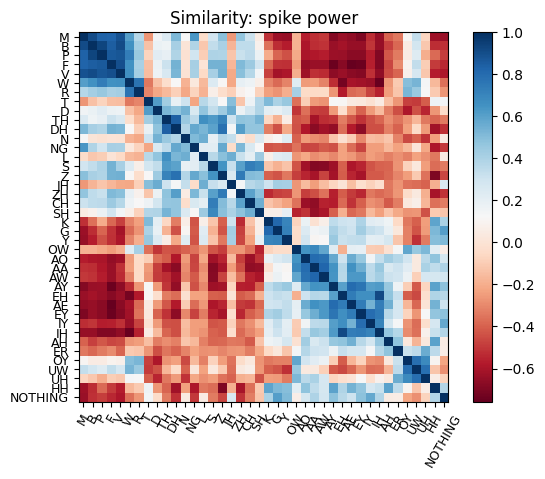

<Figure size 640x480 with 0 Axes>

In [16]:
'''similarity matrix'''
sp_flattened = [phonemes_neuralact[phonemes_chart[i]] for i in range(len(phonemes_chart))]

sp_flattened -= np.mean(sp_flattened, axis = 0)

### generate dictionary 
### dictionary for phoneme's neural activities
map_similarity = np.zeros((len(phonemes_chart), len(phonemes_chart)))

consonant_clusteredchart = ['M', 'B', 'P', 'F', 'V', 'W', 'R', 'T', 'D', 'TH', 'DH', 'N', 'NG', 'L', 'S', 'Z', 'JH', 'ZH', 'CH', 'SH', 'K', 'G', 'Y']
vowel_clusteredchart = ['OW', 'AO', 'AA', 'AW', 'AY', 'EH', 'AE', 'EY', 'IY', 'IH', 'AH', 'ER', 'OY', 'UW', 'UH', 'HH', 'NOTHING']

phoneme_clusteredchart = np.append(consonant_clusteredchart[:], vowel_clusteredchart[:])

## generate shuffle map for the arrays according to phoneme clustering
similarity_sp = np.zeros((len(phoneme_clusteredchart), len(phoneme_clusteredchart)))

shuffle_sp_flattened = [sp_flattened[phonemes_chart.index(phone)] for phone in phoneme_clusteredchart]

for i in range(len(phoneme_clusteredchart)):
    for j in range(i, len(phoneme_clusteredchart)):
#         similarity_sp[i, j] = repre_similarity(shuffle_sp_flattened[i], shuffle_sp_flattened[j])
        similarity_sp[i, j] = repre_similarity(shuffle_sp_flattened[i], shuffle_sp_flattened[j])
        similarity_sp[j, i] = similarity_sp[i, j]

## plot similarity
plt.imshow(similarity_sp, cmap='RdBu')
plt.title("Similarity: spike power")
plt.colorbar()
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation=60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9)
plt.show()

plt.clf()

              precision    recall  f1-score   support

         0.0       0.35      0.67      0.46       144
         1.0       0.18      0.19      0.18       145
         2.0       0.49      0.65      0.56       144
         3.0       0.22      0.18      0.20       141
         4.0       0.41      0.48      0.44       141
         5.0       0.24      0.17      0.20       143
         6.0       0.07      0.07      0.07       147
         7.0       0.14      0.15      0.14       143
         8.0       0.42      0.67      0.52       144
         9.0       0.12      0.11      0.12       145
        10.0       0.16      0.10      0.12       144
        11.0       0.12      0.12      0.12       148
        12.0       0.08      0.07      0.07       145
        13.0       0.11      0.13      0.12       143
        14.0       0.21      0.19      0.20       143
        15.0       0.25      0.28      0.26       143
        16.0       0.34      0.36      0.35       146
        17.0       0.18    

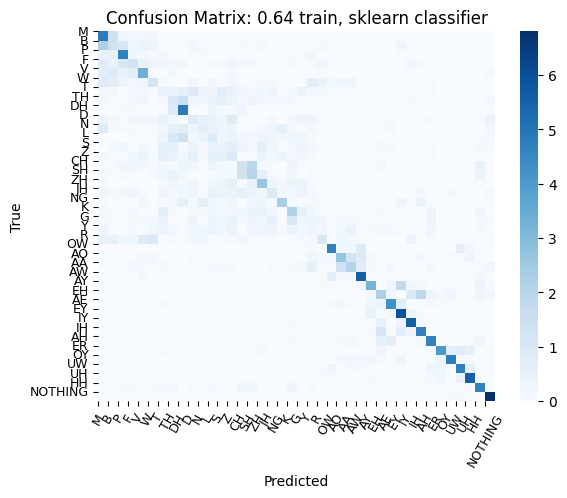

<Figure size 640x480 with 0 Axes>

In [ ]:
'''confusion matrix'''
## ML route classify
testsize = 0.36

cm_log = []
y_test_log = []
y_pred_log = []
for _ in range(20):
    X_train, X_test, y_train, y_test = train_test_split(classifier_features_s2,classifier_labels_s2, test_size = testsize, stratify = classifier_labels_s2)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_log += [cm]
    y_test_log = np.append(y_test_log, y_test)
    y_pred_log = np.append(y_pred_log, y_pred)

print(classification_report(y_test_log, y_pred_log))

cm = np.array(cm_log).mean(0)
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title(f"Confusion Matrix: {1 - testsize} train, sklearn classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation = 60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation = 0)
plt.show()
plt.clf()


4: Addition of training data from the other day, do affine transformation and try to improve classifier

In [4]:
X_s1, X_s2 = np.array([]), np.array([])

X_s1 = np.vstack(list(phonemes_neuralact.values()))
X_s2 = np.vstack(list(phonemes_neuralact_s2.values()))


'''PCA pre-process'''
# Combine both array sets for PCA fitting if you want the same PCA space
combined_arrays = np.vstack([X_s1, X_s2])

# Fit PCA to the combined arrays (extracting first 3 principal components)
pca = PCA(n_components=39)
pca.fit(combined_arrays)

# Transform the arrays separately into PCA space
X1_pca = pca.transform(X_s1)  # shape will be (40, 3)
X2_pca = pca.transform(X_s2)  # shape will be (40, 3)

A_opt, b_opt = optimize_affine_transformation(X2_pca, X1_pca, similarity_metric)


'''transform neural activities'''
feature1_pca = pca.transform(classifier_features)
feature2_pca = pca.transform(classifier_features_s2)
feature2_transformed = np.array([]) # 800 trials, 128 channels
feature2_transformed= feature2_pca @ A_opt.T + b_opt[0]

print(f"original distance: {similarity_metric(X2_pca, X1_pca)}")
print(f"transformed distance: {similarity_metric(X2_pca @ A_opt.T + b_opt[0], X1_pca)}")
print(f"distance btw transformed and source: {similarity_metric(X2_pca @ A_opt.T + b_opt[0], X2_pca)}")

filename = "F:\RiceStudy\BCI\log\classifier_performance_0407_02_L-BFGS-B.xlsx"
examine_classifiers(feature1_pca, classifier_labels, feature2_transformed, classifier_labels_s2, filename)

original distance: 0.9872417013555544
transformed distance: 0.9848012782073507
distance btw transformed and source: 0.9872249912043689
Train 1-512, Test 1-128, 10 fold
Train 2-512, Test 2-128, 10 fold
Train 2-128, Test 2-128, 10 fold
3
4
5
6
7
8


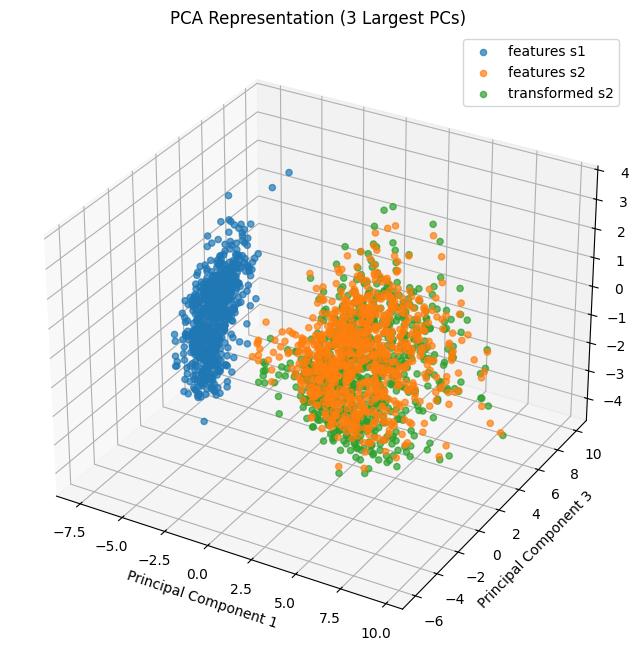

In [7]:
# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1_pca[:, 0], feature1_pca[:, 1], feature1_pca[:, 2], label='features s1', alpha=0.7)
ax.scatter(feature2_pca[:, 0], feature2_pca[:, 1], feature2_pca[:, 2], label='features s2', alpha=0.7)
ax.scatter(feature2_transformed[:, 0], feature2_transformed[:, 1], feature2_transformed[:, 2], label='transformed s2', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_ylabel('Principal Component 3')
ax.set_title('PCA Representation (3 Largest PCs)')
ax.legend()
plt.show()
plt.close()

d:\CondaEnvs\bci\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


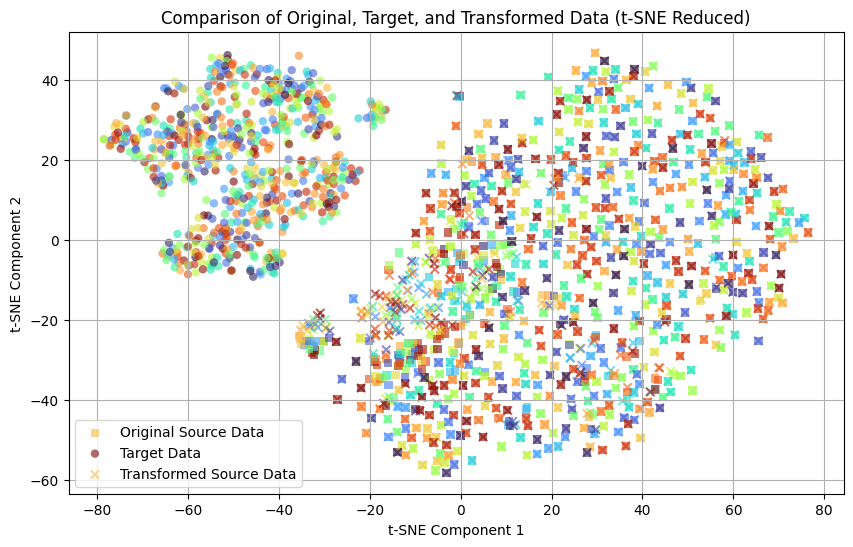

In [8]:
visualize_transformation_tsne(feature2_pca, feature1_pca, A_opt, b_opt)

-1: Addition of training data from the other day, hasn't done affine transformation and tried to improve classifier

In [ ]:
filename = "F:\RiceStudy\BCI\log\classifier_performance_0401_03.xlsx"
examine_classifiers(classifier_features, classifier_labels, classifier_features_s2, classifier_labels_s2, filename)


1
2
3
4
5
6


-1: Compare different sampling (keep training set size constant)

In [3]:
## Chance: using session 2 128 samples

print("Session 2 - 512 samples")
list1 = []
for _ in range(10):
    testsize = 0.36

    y_test_log = []
    y_pred_log = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(classifier_features_s2,classifier_labels_s2, test_size = testsize, stratify = classifier_labels_s2)

        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_test_log = np.append(y_test_log, y_test)
        y_pred_log = np.append(y_pred_log, y_pred)

    accuracy = accuracy_score(y_test_log, y_pred_log)
    list1.append(accuracy)

print("Session 2 - 128 samples")
list2 = []
for _ in range(10):
    testsize = 0.84
    X_train, X_test, y_train, y_test = train_test_split(classifier_features_s2,classifier_labels_s2, test_size = testsize, stratify = classifier_labels_s2)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    list2.append(accuracy)


print("Session 1 - 512 samples")
list3 = []
for _ in range(10):
    testsize = 0.2

    y_test_log = []
    y_pred_log = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(classifier_features,classifier_labels, test_size = testsize, stratify = classifier_labels)

        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_test_log = np.append(y_test_log, y_test)
        y_pred_log = np.append(y_pred_log, y_pred)

    accuracy = accuracy_score(y_test_log, y_pred_log)
    list3.append(accuracy)


print("Session 1 - 384 samples + session 2 - 128 samples")
list4 = []
for _ in range(10):
    sample_s1 = 384
    sample_s2 = 128

    y_test, y_pred = mix_bi_RandomForestClassifier(sample_s1, sample_s2, classifier_features, classifier_labels, classifier_features_s2, classifier_labels_s2)

    accuracy = accuracy_score(y_test, y_pred)
    list4.append(accuracy)

print("Session 1 - 384 samples + session 2 - 128 samples; demeaned together")
mean = np.mean(np.concatenate((classifier_features, classifier_features_s2), axis = 0), axis = 0)
features_s1_rearr = classifier_features.copy() - mean
features_s2_rearr = classifier_features_s2.copy() - mean

list5 = []
for _ in range(10):
    sample_s1 = 384
    sample_s2 = 128

    y_test, y_pred = mix_bi_RandomForestClassifier(sample_s1, sample_s2, features_s1_rearr, classifier_labels, features_s2_rearr, classifier_labels_s2)

    accuracy = accuracy_score(y_test, y_pred)
    list5.append(accuracy)

    
print("Session 1 - 384 samples + session 2 - 128 samples; translated")
means1 = np.mean(classifier_features, axis = 0)
means2 = np.mean(classifier_features_s2, axis = 0)
features_s1_rearr = classifier_features.copy()
features_s2_rearr = classifier_features_s2.copy() + means1 - means2

list6 = []
for _ in range(10):
    sample_s1 = 384
    sample_s2 = 128

    y_test, y_pred = mix_bi_RandomForestClassifier(sample_s1, sample_s2, features_s1_rearr, classifier_labels, features_s2_rearr, classifier_labels_s2)

    accuracy = accuracy_score(y_test, y_pred)
    list6.append(accuracy)

df = pd.DataFrame({\
    "Session 2 - 512 samples": list1,\
    "Session 2 - 128 samples": list2,\
    "Session 1 - 512 samples": list3,\
    "Session 1 - 384 samples + session 2 - 128 samples": list4,\
    "Session 1 - 384 samples + session 2 - 128 samples; demeaned together": list5,\
    "Session 1 - 384 samples + session 2 - 128 samples; translated": list6
    })
df.to_excel("F:\RiceStudy\BCI\log\classifier_performance_0401_02.xlsx", index = False)

Session 2 - 512 samples
Session 2 - 128 samples
Session 1 - 512 samples
Session 1 - 384 samples + session 2 - 128 samples
Session 1 - 384 samples + session 2 - 128 samples; demeaned together
Session 1 - 384 samples + session 2 - 128 samples; translated
